# Sentinel2 Satellite image downloader using.

Library: [Sentinelhub](https://sentinelhub-py.readthedocs.io/en/latest/index.html)

Sentinel Hub is a cloud-based platform that provides easy access to satellite imagery and geospatial data from various Earth observation missions, including Sentinel-1, Sentinel-2, and others.

In this notebook, we explore how to access and download satellite imagery from Sentinel Hub using its powerful [API](https://dataspace.copernicus.eu/analyse/apis). By leveraging Sentinel Hub’s capabilities, we can retrieve data from these missions and process it to meet specific analysis requirements, making it a useful tool for environmental monitoring, geospatial analysis, and research applications.




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    MosaickingOrder,
)

import datetime
import os
import getpass
import matplotlib.pyplot as plt
import numpy as np

### API and Authentication


In [3]:
# Only run this cell if you have not created a configuration.
config = SHConfig()
config.sh_client_id = 'sh-349741a9-2278-4b14-912b-f9bfa6e27d63'
config.sh_client_secret = 'EvhABuBoJR6i2yXZ3B91KKSUyWXq3fX4'

config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'
config.save("cdse")

In [4]:
config = SHConfig("cdse")

### Define bounding box and resolution


In [5]:
bbox_wgs84 = [9.1170, 47.6330, 9.2180, 47.7160]
resolution = 30

aoi_bbox = BBox(bbox=bbox_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

In [6]:
time_interval = ('2023-06-01', '2023-08-31')

### Satellite image Download and Visualization


In [7]:
evalscript_true_color = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }
    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

### True color

In [8]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [9]:
true_color_imgs = request_true_color.get_data()

In [10]:
plot_image(
    true_color_imgs[0],
    factor=3.5 / 255,
    clip_range=(0, 1),
    figsize=(8,8)
)

NameError: name 'plot_image' is not defined

### All bands

In [17]:
## Save
save_images = True
save_directory = "./Sentinelhub/"

In [18]:
request_all_bands = SentinelHubRequest(
    data_folder = save_directory,
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=time_interval,
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [19]:
all_bands_response = request_all_bands.get_data(save_data=save_images)

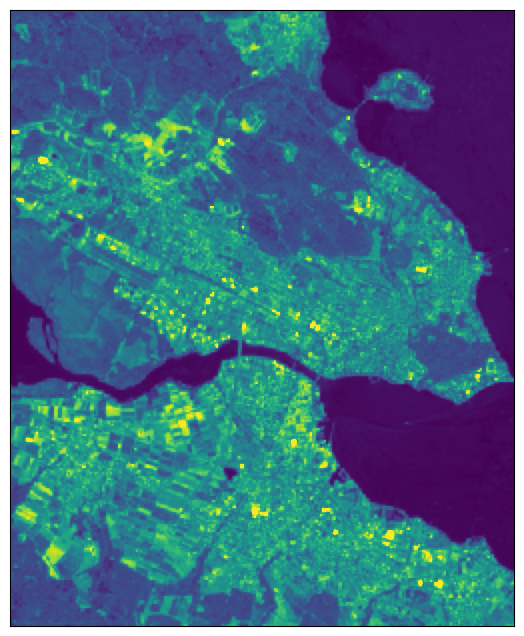

In [13]:
plot_image(
    all_bands_response[0][:, :, 12],
    factor=3.5 / 1e4,
    vmax=1,
    figsize=(8,8))

In [20]:
print(np.shape(all_bands_response))

(1, 308, 252, 13)


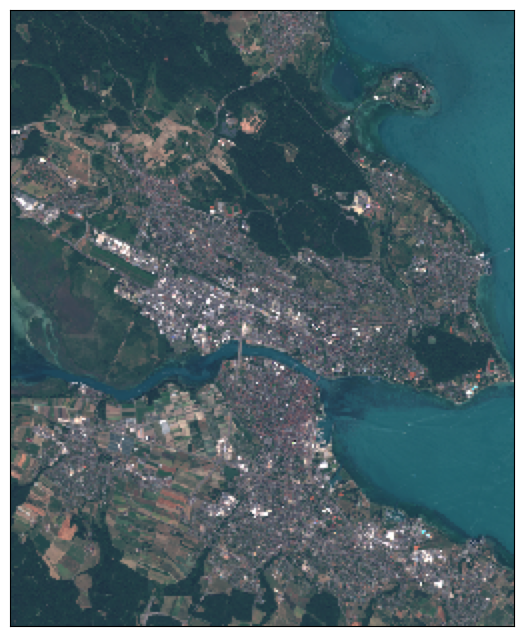

In [21]:
plot_image(
    all_bands_response[0][:, :, [3, 2, 1]],
    factor=3.5 / 1e4,
    clip_range=(0, 1),
    figsize=(8,8))

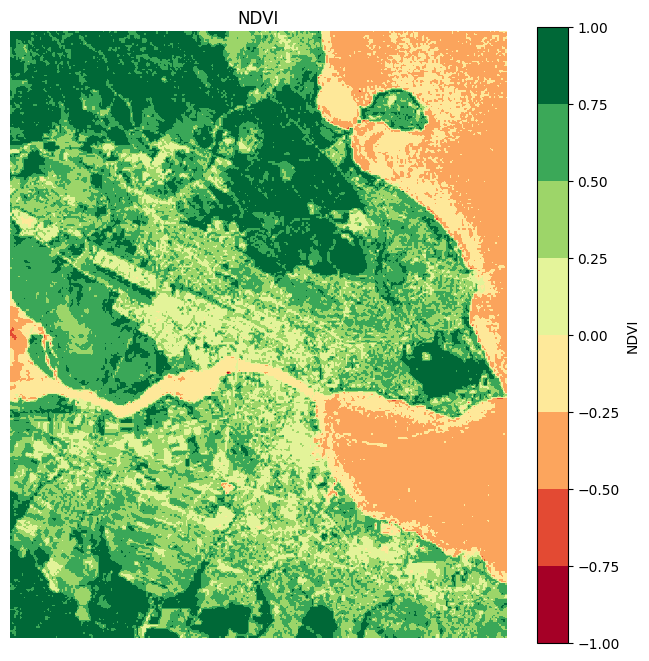

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the NIR (Band 8) and Red (Band 4) bands
nir = all_bands_response[0][:, :, 7]
red = all_bands_response[0][:, :, 3]

# Compute NDVI (Add a small number to avoid division by zero)
ndvi = (nir - red) / (nir + red + 1e-10) 

# Plot NDVI
plt.figure(figsize=(8, 8))
cmap = plt.get_cmap('RdYlGn',8)
plt.imshow(ndvi, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI')
plt.axis('off')
plt.show()
